In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
from sklearn.decomposition import PCA

In [120]:
def process_vector_df(path):
    pass

In [5]:
s3_client = boto3.client('s3')
bucket_name = 'jarednewstudy'
key = 'train_mels_vec.csv'

In [67]:
obj = s3_client.get_object(Bucket=bucket_name, Key=key)

In [68]:
df = pd.read_csv(obj['Body'])

In [70]:
def choose_target(df, target):
    """
    Returns y as ndarray, X as a dataframe
    """
    df[target] = pd.get_dummies(df)['labels_{}'.format(target)]
    y = df[target].values
    X = df.drop(columns=['Unnamed: 0', 'labels', 'fname', target])
    return X, y

In [91]:
X, y = choose_target(df, 'Purr')

In [87]:
y[y==1]

array([1, 1, 1, 1], dtype=uint8)

In [107]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,16375,16376,16377,16378,16379,16380,16381,16382,16383,Bark
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-16.349299,-18.031488,-17.434985,-17.300537,-17.570010,-17.667189,-18.032827,-17.449463,-17.705600,-16.719248,...,-53.872248,-54.715844,-54.467296,-54.514963,-54.475302,-54.406091,-54.392383,-54.082551,-54.034307,0.004000
std,20.127993,20.688209,20.367240,19.875046,20.854102,20.937940,20.514703,20.464548,20.452823,20.091427,...,12.575905,11.814840,11.998541,12.192558,11.897926,11.906986,11.975822,12.247739,11.965737,0.063151
min,-86.838570,-93.673386,-84.644859,-73.073288,-82.085945,-82.684784,-81.623718,-80.501129,-82.684784,-82.684784,...,-86.038353,-86.038353,-86.038353,-98.188225,-86.038353,-86.038353,-86.038353,-88.565170,-87.100159,0.000000
25%,-29.178788,-31.760992,-29.661211,-29.355464,-30.785376,-30.901316,-31.233475,-30.523108,-30.386949,-29.219077,...,-61.786613,-62.226665,-62.337007,-62.346794,-62.325818,-62.276100,-62.276100,-61.809067,-61.838096,0.000000
50%,-14.907685,-16.178761,-15.187243,-15.675508,-15.648202,-14.970316,-15.598800,-15.420786,-15.892051,-14.594942,...,-54.025717,-54.517656,-54.192310,-54.426260,-54.097078,-54.230137,-54.210979,-53.630930,-53.744453,0.000000
75%,-2.247474,-4.087688,-3.802814,-4.690444,-2.832629,-3.688863,-3.928626,-3.223348,-3.495781,-3.097138,...,-46.829165,-47.249040,-47.085740,-47.133106,-46.901263,-47.075775,-47.252785,-46.903483,-46.476848,0.000000
max,37.634338,36.299622,37.215313,35.153126,35.357887,37.711174,35.847908,37.507835,39.096722,39.171272,...,0.000000,0.000000,0.841981,0.000000,0.000000,0.000000,0.000000,0.871323,0.000000,1.000000


In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [103]:
y_train[y_train==1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [118]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [95]:
gbc = GradientBoostingClassifier(learning_rate=0.05,
                                n_estimators=200,
                                max_features=5000,
                                 random_state=8,
                                 verbose=1
                                )
gbc.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.1811           39.76s
         2           0.1729           40.38s
         3           0.1705           40.13s
         4           0.1676           40.13s
         5           0.1662           40.26s
         6           0.1647           40.51s
         7           0.1612           40.52s
         8           0.1447           41.72s
         9           0.1293           42.58s
        10           0.1214           43.10s
        20           0.0744           43.12s
        30           0.0517           41.76s
        40           0.0377           40.42s
        50           0.0282           37.78s
        60           0.0222           35.15s
        70           0.0182           32.33s
        80           0.0141           30.02s
        90           0.0117           27.52s
       100           0.0094           25.10s
       200           0.0015            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=5000, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [96]:
y_preds = gbc.predict(X_test)

In [97]:
y_probs = gbc.predict_proba(X_test)

In [98]:
acc = accuracy_score(y_test, y_preds)
prec = precision_score(y_test, y_preds)
rec = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

/Users/jared/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jared/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [102]:
f1

0.0

In [ ]:
print('accuracy:')

In [82]:
y_preds[y_preds==1]

array([], dtype=uint8)

In [80]:
f1

0.0

## PCA

In [128]:
pca = PCA(n_components=100)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [129]:
def scree_plot(ax, pca, n_components_to_plot=100, title=None):
    """Make a scree plot showing the variance explained (i.e. varaince of the projections) for the principal components in a fit sklearn PCA object.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    pca: sklearn.decomposition.PCA object.
      A fit PCA object.
      
    n_components_to_plot: int
      The number of principal components to display in the skree plot.
      
    title: str
      A title for the skree plot.
    """
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    ax.plot(ind, vals, color='blue')
    ax.scatter(ind, vals, color='blue', s=50)

    for i in range(num_components):
        ax.annotate(r"{:2.2f}%".format(vals[i]), 
                   (ind[i]+0.2, vals[i]+0.005), 
                   va="bottom", 
                   ha="center", 
                   fontsize=12)

    ax.set_xticklabels(ind, fontsize=12)
    ax.set_ylim(0, max(vals) + 0.05)
    ax.set_xlim(0 - 0.45, n_components_to_plot + 0.45)
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=16)


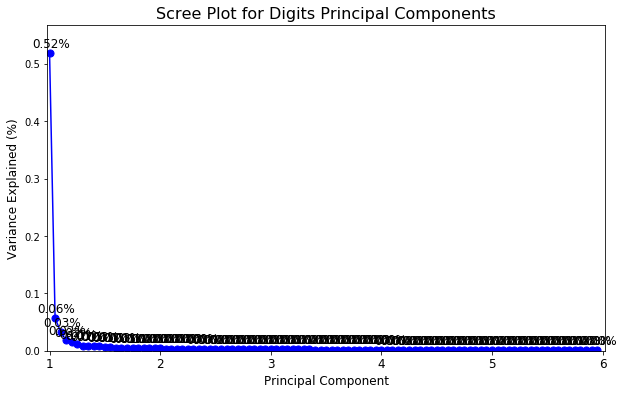

In [130]:
fig, ax = plt.subplots(figsize=(10, 6))
scree_plot(ax, pca, title="Scree Plot for Digits Principal Components")